# **Speech Emotion Classification using LSTM and RNN**

In [156]:
import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
import wave
import matplotlib.pyplot as plt
import collections

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, Dense, Dropout, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [157]:
# This function obatains the mfcc features and obtain the mean of each dimension
# Input is path to the .wav file
# Output is the mfcc_features
def extract_mfcc(wav_file_name):
    y, sr = librosa.load(wav_file_name)
    mfccs = np.mean(librosa.feature.mfcc(y = y, sr = sr, n_mfcc = 40).T, axis = 0) 
    
    return mfccs   
    

### **Load Ryerson Audio-Visual Datbase of Emotional Speech and Song (RAVDESS)**

In [158]:
# Load dataset
ravdess_speech_labels = [] 
ravdess_speech_data = [] 
ravdess_speech_data_filepath = []
ravdess_speech_data_filename = []
for dir_name, _, file_names in os.walk("../data/ravdess"):
    for file_name in file_names:
        # print(os.path.join(dir_name, file_name))
        ravdess_speech_labels.append(int(file_name[7 : 8]) - 1)
        wav_file_name = os.path.join(dir_name, file_name)
        ravdess_speech_data.append(extract_mfcc(wav_file_name))
        ravdess_speech_data_filepath.append(wav_file_name)
        ravdess_speech_data_filename.append(file_name)
        
print(len(ravdess_speech_data))
print(len(ravdess_speech_labels))
print("Finished Loading the Dataset")

2880
2880
Finished Loading the Dataset


In [159]:

failed_files = []
for i, arr in enumerate(ravdess_speech_data):
    if arr is None or (isinstance(arr, (np.ndarray, list)) and np.any(pd.isnull(arr))):
        failed_files.append(ravdess_speech_data_filename[i])
print(f"Total failed/corrupted audio files: {len(failed_files)}")
if failed_files:
    print("List of corrupted/missing files:")
    print(failed_files)
else:
    print("No missing or corrupted files detected in extracted features.")


Total failed/corrupted audio files: 0
No missing or corrupted files detected in extracted features.


### **Exploratory Data Analysis**

In [160]:
label_counts = collections.Counter(ravdess_speech_labels)
print("Label distribution:")
for k, v in sorted(label_counts.items()):
    print(f"Label {k} ('{emotion_map[k]}'): {v} samples")


Label distribution:
Label 0 ('neutral'): 192 samples
Label 1 ('calm'): 384 samples
Label 2 ('happy'): 384 samples
Label 3 ('sad'): 384 samples
Label 4 ('angry'): 384 samples
Label 5 ('fearful'): 384 samples
Label 6 ('disgust'): 384 samples
Label 7 ('surprised'): 384 samples


In [161]:
# Mapping from numerical code to emotion label
emotion_map = {
    "1": "neutral",
    "2": "calm",
    "3": "happy",
    "4": "sad",
    "5": "angry",
    "6": "fearful",
    "7": "disgust",
    "8": "surprised"
}

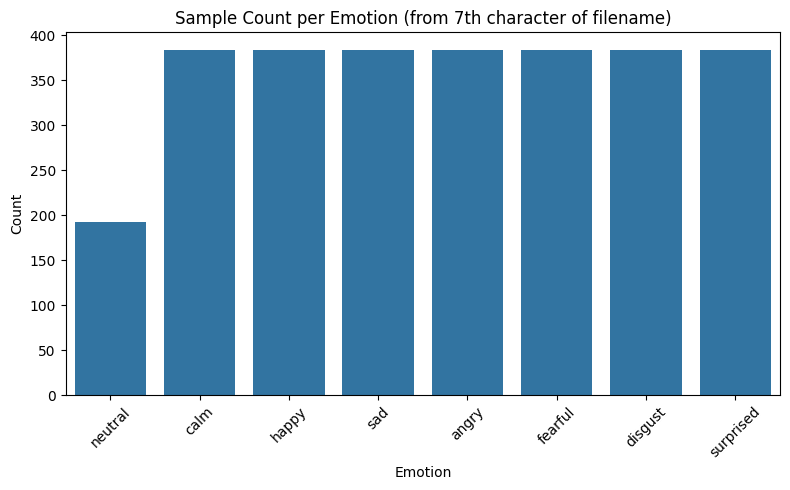

In [162]:

# Extract emotion number from 7th index (as string)
emotion_numbers = [fname[7] for fname in ravdess_speech_data_filename]
emotion_labels = [emotion_map.get(num, "unknown") for num in emotion_numbers]

# Build DataFrame for plotting
df = pd.DataFrame({"Emotion": emotion_labels})

# Create count plot with seaborn
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="Emotion", order=list(emotion_map.values()))
plt.title("Sample Count per Emotion (from 7th character of filename)")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [163]:
# Convert MFCC data to DataFrame (shape: samples x features)
mfcc_df = pd.DataFrame(np.array(ravdess_speech_data), columns=[f"MFCC_{i+1}" for i in range(40)])

# Compute summary statistics for each feature
desc_stats = mfcc_df.describe().T  # Includes mean, std, min, 25%, 50%, 75%, max
print(desc_stats)


          count        mean         std         min         25%         50%  \
MFCC_1   2880.0 -588.125854  101.888680 -848.593628 -663.823593 -594.653168   
MFCC_2   2880.0   48.375023   15.908984   -5.350828   38.130108   48.631124   
MFCC_3   2880.0   -5.164897   12.506803  -55.784222  -12.940163   -4.887666   
MFCC_4   2880.0    7.669101    7.938345  -20.430019    2.322943    7.746552   
MFCC_5   2880.0    0.667920    8.523410  -23.257389   -5.929372    0.587622   
MFCC_6   2880.0   -4.493579    6.984804  -26.764631   -9.278186   -4.834437   
MFCC_7   2880.0   -5.687483    6.103169  -25.929209  -10.057318   -5.973680   
MFCC_8   2880.0   -8.888741    5.435184  -25.701900  -12.892340   -8.683557   
MFCC_9   2880.0   -6.727094    4.590566  -23.752399   -9.603360   -6.533266   
MFCC_10  2880.0   -1.941090    4.096664  -19.606728   -4.666875   -2.058461   
MFCC_11  2880.0   -3.302415    4.574499  -17.061312   -6.586596   -3.261797   
MFCC_12  2880.0   -3.466555    4.022083  -15.884318 

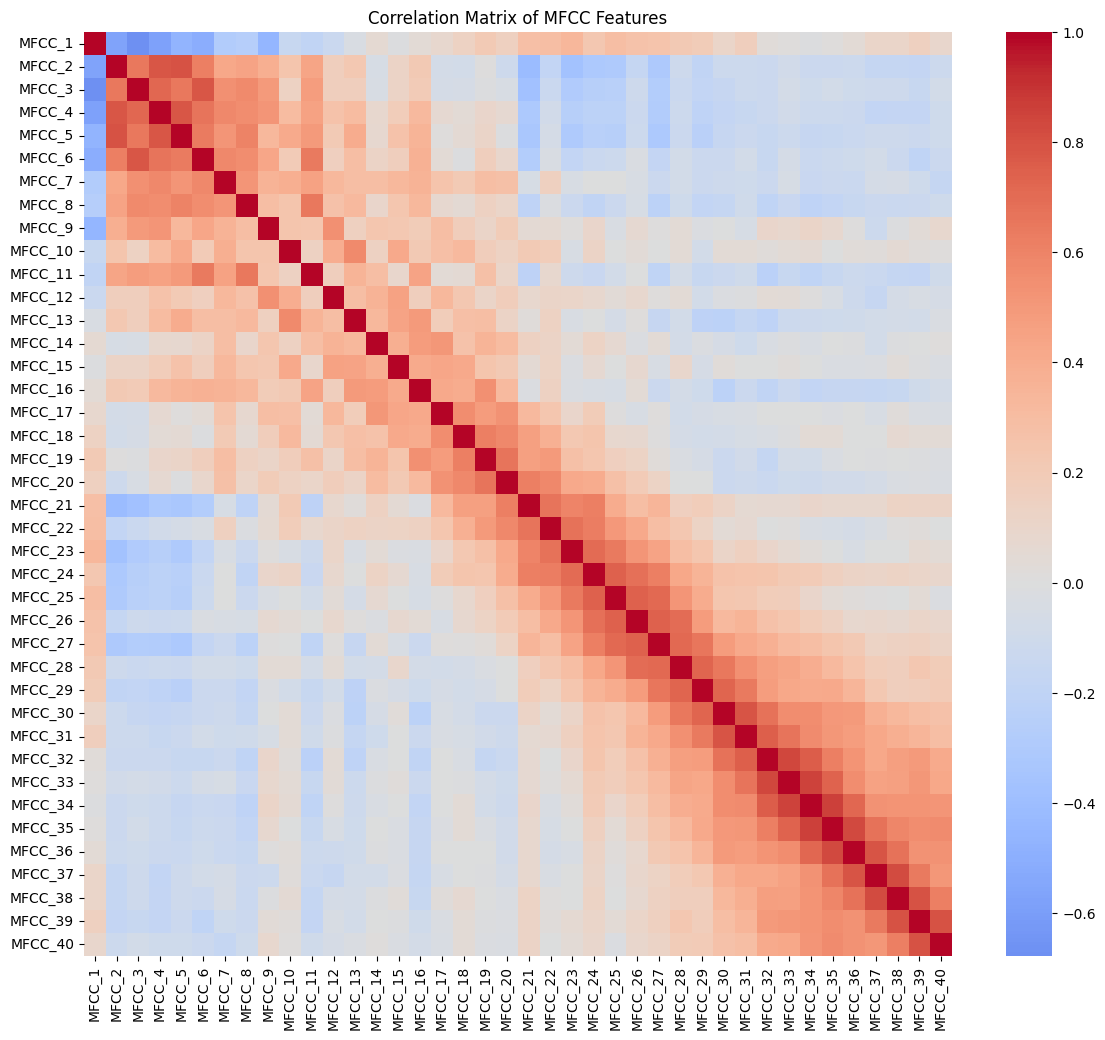

In [164]:
corr_matrix = mfcc_df.corr()
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False)
plt.title("Correlation Matrix of MFCC Features")
plt.show()

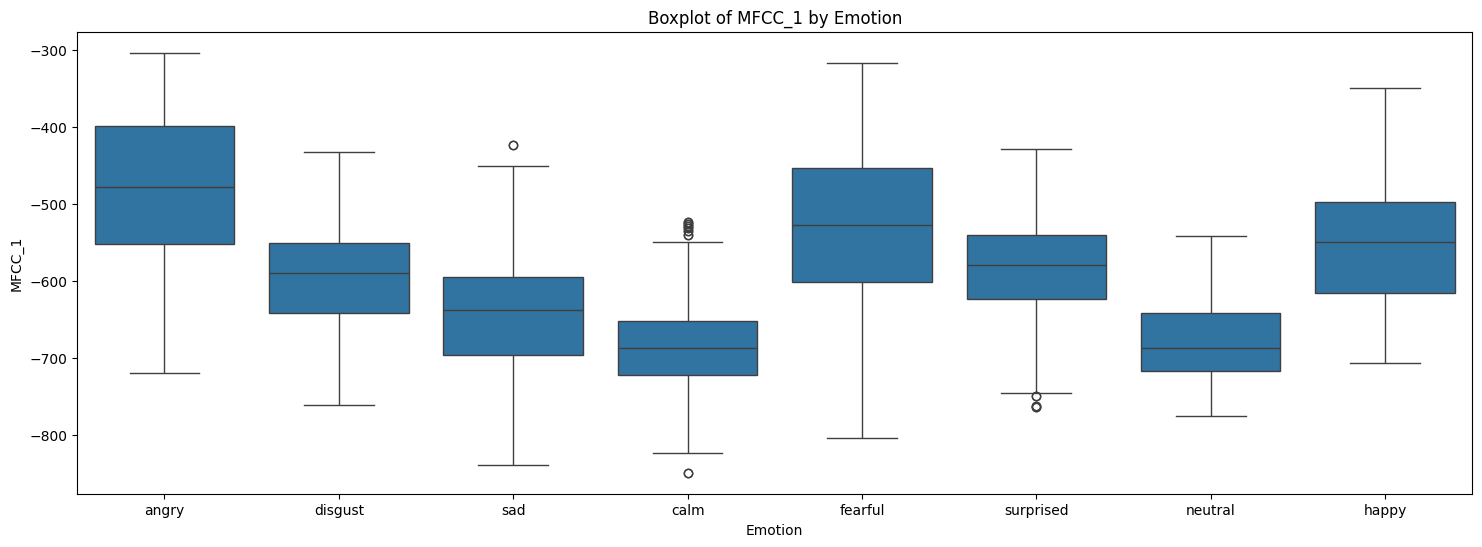

In [165]:
emotion_map = {
    0: "neutral",
    1: "calm",
    2: "happy",
    3: "sad",
    4: "angry",
    5: "fearful",
    6: "disgust",
    7: "surprised"
}

mfcc_df['Emotion'] = [emotion_map[label] for label in ravdess_speech_labels]

plt.figure(figsize=(18, 6))
sns.boxplot(data=mfcc_df, x='Emotion', y='MFCC_1')
plt.title("Boxplot of MFCC_1 by Emotion")
plt.show()

# For more features, loop or plot separately as needed


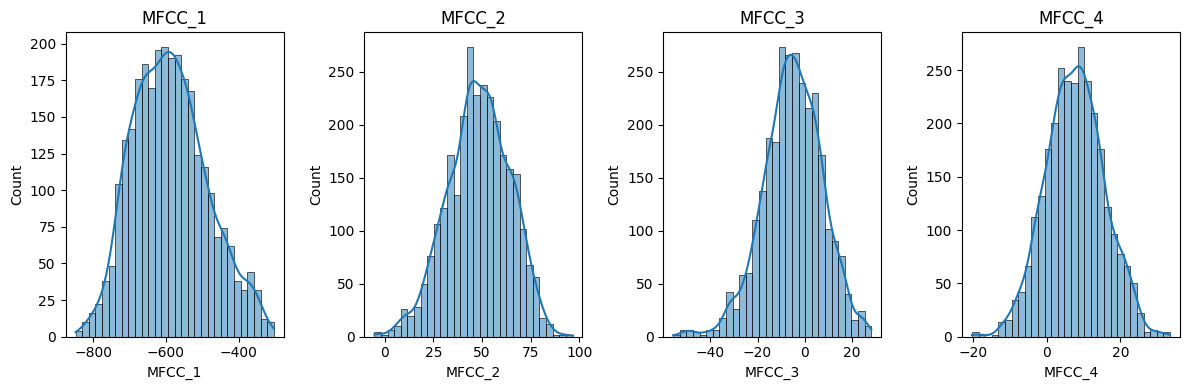

In [166]:
plt.figure(figsize=(12, 4))
for i in range(4):  # Plot first 4 MFCCs as example; adjust range(40) for all
    plt.subplot(1, 4, i+1)
    sns.histplot(mfcc_df[f"MFCC_{i+1}"], bins=30, kde=True)
    plt.title(f"MFCC_{i+1}")
plt.tight_layout()
plt.show()


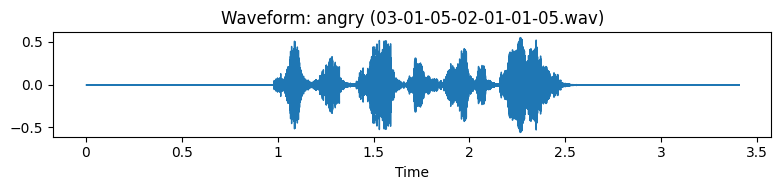

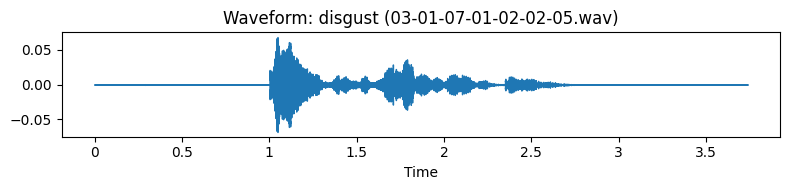

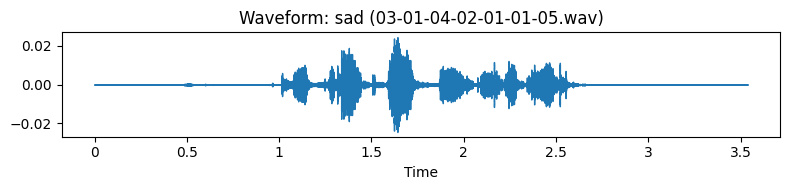

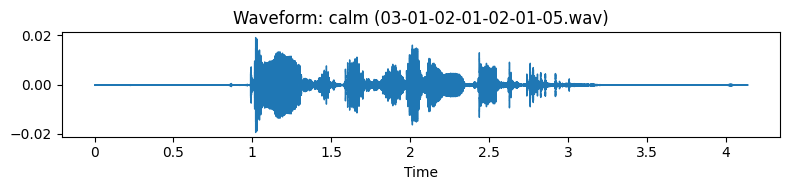

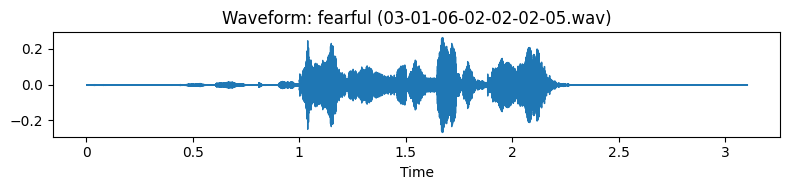

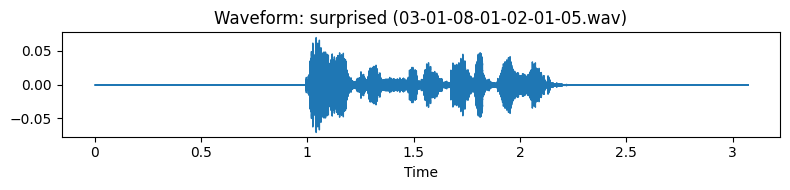

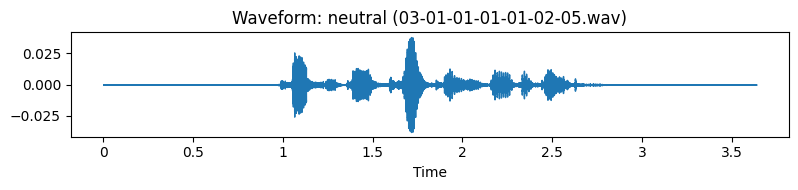

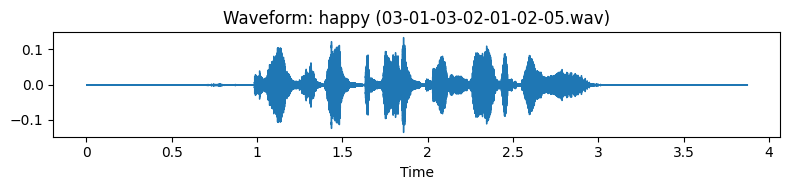

In [167]:
chosen_files = {}
# Pick first occurrence example file per emotion
for fname, label in zip(ravdess_speech_data_filename, ravdess_speech_labels):
    if label not in chosen_files:
        chosen_files[label] = fname

for label, fname in chosen_files.items():
    filepath = None
    # Find matching full filepath
    for fpath in ravdess_speech_data_filepath:
        if fname in fpath:
            filepath = fpath
            break
    y, sr = librosa.load(filepath)
    plt.figure(figsize=(8, 2))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform: {emotion_map[label]} ({fname})")
    plt.tight_layout()
    plt.show()


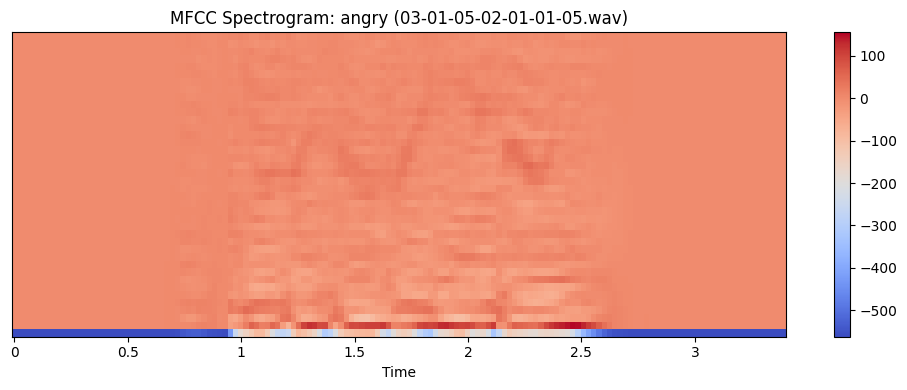

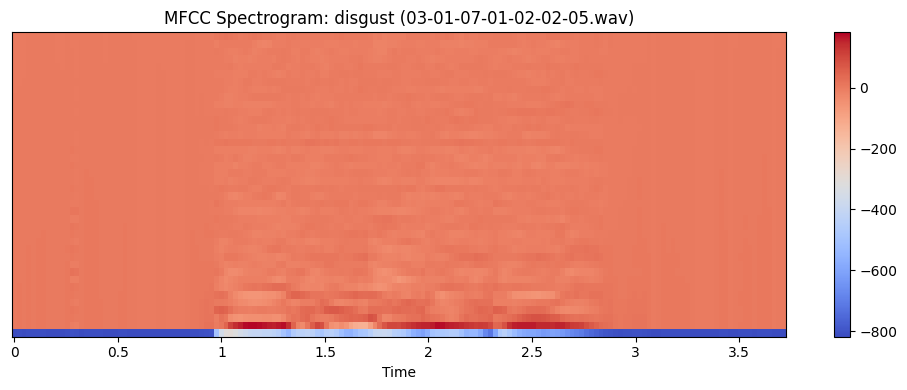

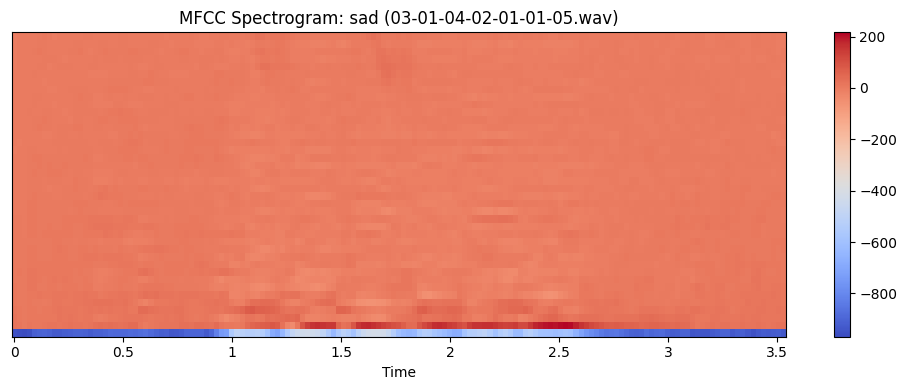

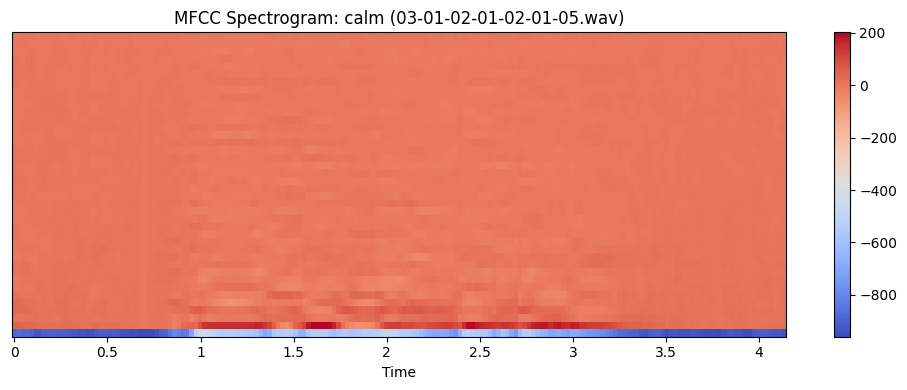

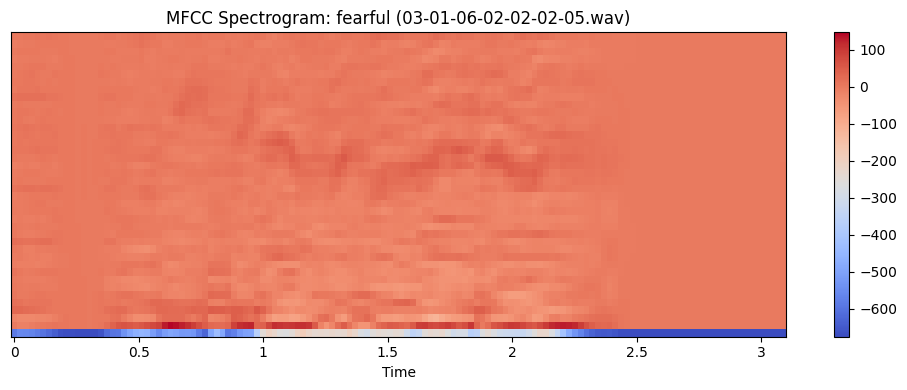

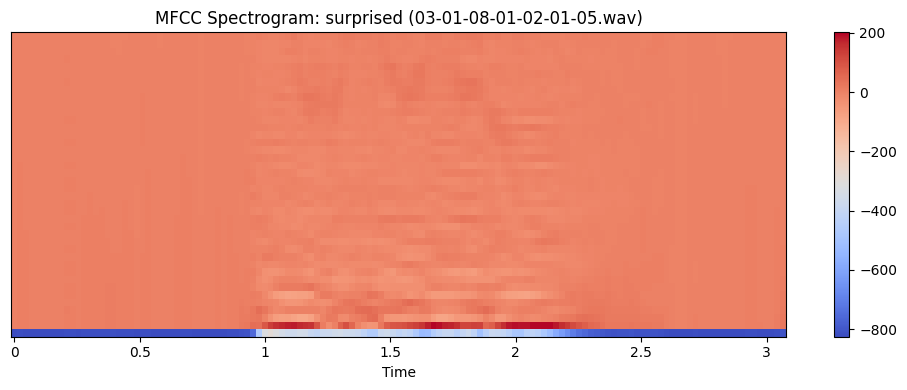

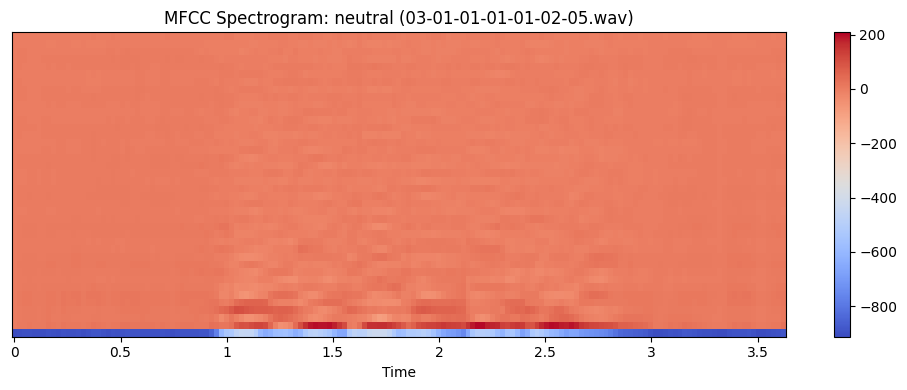

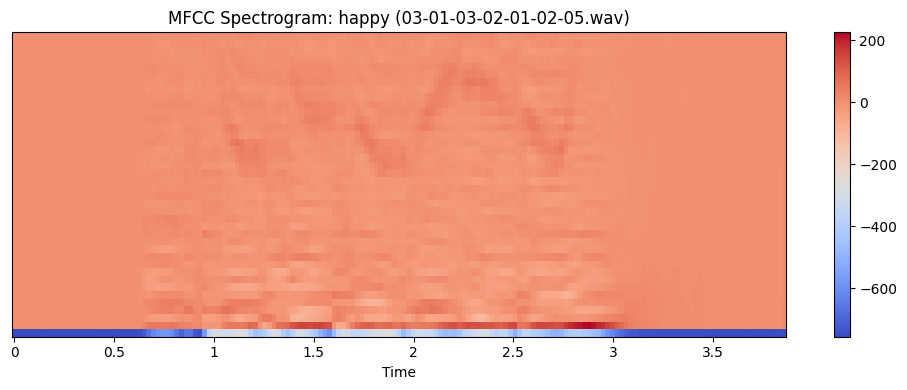

In [168]:
for label, fname in chosen_files.items():
    filepath = None
    for fpath in ravdess_speech_data_filepath:
        if fname in fpath:
            filepath = fpath
            break
    y, sr = librosa.load(filepath)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, x_axis='time', sr=sr)
    plt.colorbar()
    plt.title(f"MFCC Spectrogram: {emotion_map[label]} ({fname})")
    plt.tight_layout()
    plt.show()


In [169]:
# To convert data and label to array
ravdess_speech_data_array = np.asarray(ravdess_speech_data)
ravdess_speech_label_array = np.array(ravdess_speech_labels)
ravdess_speech_label_array.shape 

# # Normalize features
# scaler = StandardScaler()
# ravdess_speech_data_array = scaler.fit_transform(ravdess_speech_data_array)

# Make categorical labels
labels_categorical = to_categorical(ravdess_speech_label_array)
labels_categorical.shape

(2880, 8)

In [170]:
x_train, x_test, y_train, y_test = train_test_split(np.array(ravdess_speech_data_array),labels_categorical, test_size=0.2, random_state=9)

In [171]:
# split the data into training, validation, and test sets
number_of_samples = ravdess_speech_data_array.shape[0]
training_samples = int(0.8 * number_of_samples)
validation_samples = int(0.1 * number_of_samples)
test_samples = int(0.1 * number_of_samples)

In [172]:
#Define the LSTM model
def create_model_LSTM():
    model = Sequential()
    model.add(LSTM(128, return_sequences=False, input_shape=(40, 1)))
    model.add(Dense(64))
    model.add(Dropout(0.4))
    model.add(Activation('relu'))
    model.add(Dense(32))
    model.add(Dropout(0.4))
    model.add(Activation('relu'))
    model.add(Dense(8))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Define the RNN model
def create_model_RNN():
    model = Sequential()
    model.add(SimpleRNN(128, return_sequences=True, input_shape=(40, 1)))
    model.add(Dropout(0.3))
    model.add(SimpleRNN(64, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(8, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [173]:
w = np.expand_dims(ravdess_speech_data_array[:training_samples], axis = -1)


In [174]:
w.shape

(2304, 40, 1)

## **LSTM Model Training**

In [175]:
# Train using LSTM model
model_LSTM = create_model_LSTM()
history_LSTM = model_LSTM.fit(np.expand_dims(ravdess_speech_data_array[:training_samples], axis = -1), labels_categorical[:training_samples], validation_data=(np.expand_dims(ravdess_speech_data_array[training_samples:training_samples + validation_samples], axis = -1), labels_categorical[training_samples:training_samples + validation_samples]), epochs=130, shuffle=True)


Epoch 1/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.1329 - loss: 2.0747 - val_accuracy: 0.1840 - val_loss: 1.9895
Epoch 2/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2156 - loss: 1.9982 - val_accuracy: 0.2569 - val_loss: 1.9306
Epoch 3/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2458 - loss: 1.9362 - val_accuracy: 0.2500 - val_loss: 1.8708
Epoch 4/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2721 - loss: 1.8909 - val_accuracy: 0.2882 - val_loss: 1.8514
Epoch 5/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2633 - loss: 1.8451 - val_accuracy: 0.2708 - val_loss: 1.8451
Epoch 6/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2933 - loss: 1.8353 - val_accuracy: 0.2847 - val_loss: 1.8195
Epoch 7/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2738 - loss: 1.8267 - val_accuracy: 0.3194 - val_loss: 1.8125
Epoch 8/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3072 - loss: 1.8182 - val_accuracy: 0.2882

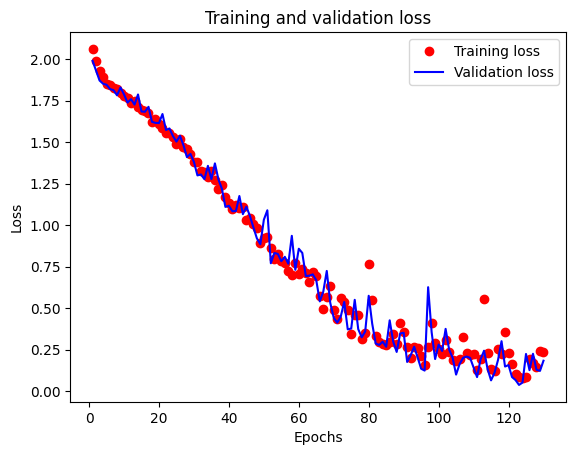

In [176]:
# Loss plots using LSTM model
lstm_loss = history_LSTM.history['loss']
lstm_val_loss = history_LSTM.history['val_loss']

epochs = range(1, len(lstm_loss) + 1)

plt.plot(epochs, lstm_loss, 'ro', label='Training loss')
plt.plot(epochs, lstm_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

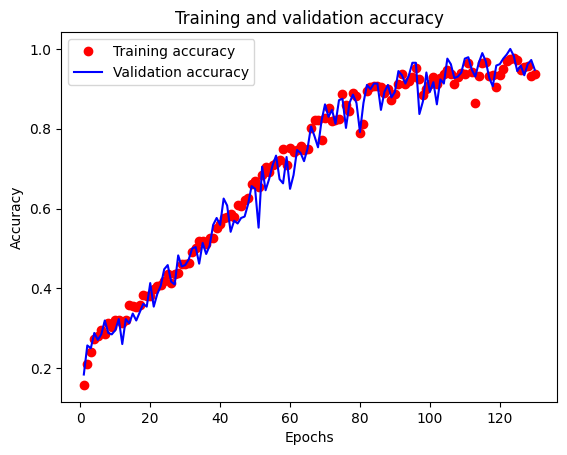

In [177]:
# Accuracy plots using LSTM model
lstm_acc = history_LSTM.history['accuracy']
lstm_val_acc = history_LSTM.history['val_accuracy']

epochs = range(1, len(lstm_acc) + 1)

plt.plot(epochs, lstm_acc, 'ro', label='Training accuracy')
plt.plot(epochs, lstm_val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## **RNN Model Training**

In [178]:

model_RNN = create_model_RNN()
history_RNN = model_RNN.fit(np.expand_dims(ravdess_speech_data_array[:training_samples], axis = -1), labels_categorical[:training_samples], validation_data=(np.expand_dims(ravdess_speech_data_array[training_samples:training_samples + validation_samples], axis = -1), labels_categorical[training_samples:training_samples + validation_samples]), epochs=130, shuffle=True)

Epoch 1/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.1551 - loss: 2.1192 - val_accuracy: 0.2083 - val_loss: 2.0390
Epoch 2/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1404 - loss: 2.0853 - val_accuracy: 0.2396 - val_loss: 2.0187
Epoch 3/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1769 - loss: 2.0400 - val_accuracy: 0.2188 - val_loss: 1.9930
Epoch 4/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2115 - loss: 2.0364 - val_accuracy: 0.2292 - val_loss: 2.0067
Epoch 5/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1973 - loss: 2.0352 - val_accuracy: 0.2812 - val_loss: 1.9752
Epoch 6/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2102 - loss: 1.9957 - val_accuracy: 0.2257 - val_loss: 1.9819
Epoch 7/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2152 - loss: 1.9807 - val_accuracy: 0.2222 - val_loss: 1.9389
Epoch 8/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2251 - loss: 1.9757 - val_accuracy: 0.2500 -

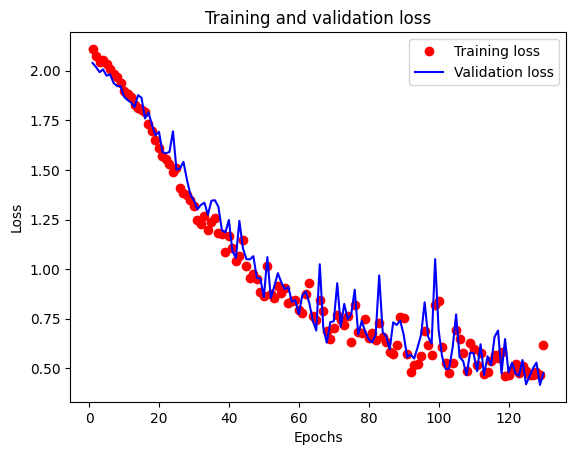

In [179]:
# Loss plots using RNN model
rnn_loss = history_RNN.history['loss']
rnn_val_loss = history_RNN.history['val_loss']

epochs = range(1, len(rnn_loss) + 1)

plt.plot(epochs, rnn_loss, 'ro', label='Training loss')
plt.plot(epochs, rnn_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

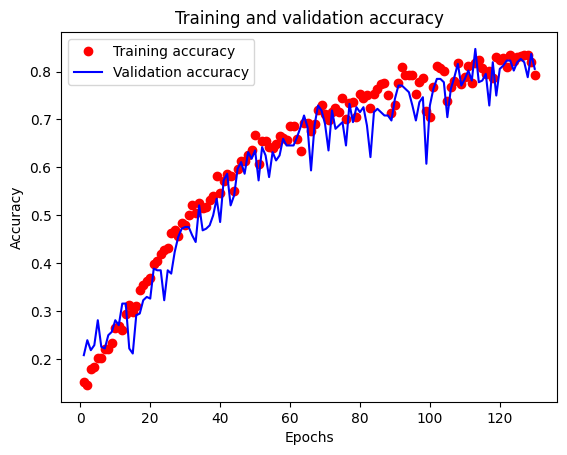

In [180]:
# Accuracy plots using RNN model
rnn_acc = history_RNN.history['accuracy']
rnn_val_acc = history_RNN.history['val_accuracy']

epochs = range(1, len(rnn_acc) + 1)

plt.plot(epochs, rnn_acc, 'ro', label='Training accuracy')
plt.plot(epochs, rnn_val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Evaluating the models

In [181]:
model_LSTM.evaluate(np.expand_dims(ravdess_speech_data_array[training_samples + validation_samples:], axis=-1), labels_categorical[training_samples + validation_samples:])

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9712 - loss: 0.1464 


[0.17467090487480164, 0.9548611044883728]

In [182]:
model_RNN.evaluate(np.expand_dims(ravdess_speech_data_array[training_samples + validation_samples:], axis=-1), labels_categorical[training_samples + validation_samples:])

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7829 - loss: 0.5671 


[0.5277449488639832, 0.8055555820465088]

### Saving the Models

In [183]:
# Save LSTM model
model_LSTM.save('../src/model_LSTM.keras')

# Save RNN model
model_RNN.save('../src/model_RNN.keras')